In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, TimeDistributed
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy as scipy
from keras.callbacks import TensorBoard
from keras.regularizers import l1, activity_l1
from keras.regularizers import l2, activity_l2
from sklearn import preprocessing  
#from datetime 
import datetime 
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
import pickle
from keras.preprocessing.sequence import pad_sequences
import time

Using TensorFlow backend.


In [3]:
numpy.random.seed(7)

In [4]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [5]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
df_train['year'] = pd.DatetimeIndex(df_train.datetime).year

df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test['year'] = pd.DatetimeIndex(df_test.datetime).year

In [6]:
# combine train and test data into one df
df = df_train.append(df_test)

# lowercase column names
#df.columns = map(str.lower, df.columns)

df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']

#df['month'] = pd.DatetimeIndex(df.datetime).month
#df['day'] = pd.DatetimeIndex(df.datetime).dayofweek
#df['hour'] = pd.DatetimeIndex(df.datetime).hour
#df['year'] = pd.DatetimeIndex(df.datetime).year

df = df.drop('datetime', axis=1)
drange = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df = df.reindex(drange)

df = df[df_train.drop(['datetime', 'casual', 'registered','count'],axis=1).columns]

# parse datetime colum & add new time related columns
#dt = pd.DatetimeIndex(df['datetime'])
#df.set_index(dt, inplace=True)

dt = pd.DatetimeIndex(df_train['datetime'])
df_train.set_index(dt, inplace=True)
dt = pd.DatetimeIndex(df_test['datetime'])
df_test.set_index(dt, inplace=True)

df["weather"] = df["weather"].interpolate(method='time').apply(np.round)
df["temp"] = df["temp"].interpolate(method='time')
df["atemp"] = df["atemp"].interpolate(method='time')
df["humidity"] = df["humidity"].interpolate(method='time').apply(np.round)
df["windspeed"] = df["windspeed"].interpolate(method='time')

df["season"] = df["season"].interpolate(method='time').apply(np.round)
df["holiday"] = df["holiday"].interpolate(method='time').apply(np.round)
df["workingday"] = df["workingday"].interpolate(method='time').apply(np.round)

df["month"] = df["month"].interpolate(method='time').apply(np.round)
df["day"] = df["day"].interpolate(method='time').apply(np.round)
df["hour"] = df["hour"].interpolate(method='time').apply(np.round)
df["year"] = df["year"].interpolate(method='time').apply(np.round)

In [7]:
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# tax day
df_train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1

#storms
df_test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#tornado
df_train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [8]:
df_train_train = df_train.drop(['datetime','casual','registered','count'], axis = 1)
#df_train_train = df_train_train.drop(['season','workingday','weather','holiday'], axis = 1)
df_test_train = df_train['count']

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_test_train.values.astype('float32').reshape(-1,1))
scalerx = MinMaxScaler(feature_range=(-1, 1))
scalerx.fit(df_train_train.values.astype('float32'))
df = df.apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
timesteps = 3
def preprocess_nn(datax, datay):
    indexx = pd.DatetimeIndex(datax['datetime']).day 
    testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
    datax[datax.drop('datetime',axis=1).columns] = datax[datax.drop('datetime',axis=1).columns].apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
    datay['count'] = scaler.transform(datay['count'])
    #train_Y_n = scaler.transform(datay.reshape(-1,1))
    train_x = datax[~testindex]#.astype('float32')
    train_y = datay[~testindex]#.astype('float32')
    test_x = datax[testindex]#.astype('float32')
    test_y = datay[testindex]#.astype('float32')
    return train_x, train_y, test_x, test_y
#def preshape_nn(data_x):
#    data_x = numpy.reshape(data_x, (data_x.shape[0]/timesteps, timesteps, data_x.shape[1]))
#    return data_x
def preshape_nn(data_set, look_back = timesteps):
    out1= []
    for val in range(len(data_set) - look_back + 1):
        end1 = datetime.datetime.strptime(data_set['datetime'].values[look_back - 1 + val],"%Y-%m-%d %H:%M:%S" )
        timesteps_array = []
        for it in range(look_back): 
            timesteps_array.append(np.datetime64(end1))
            end1 = end1 - datetime.timedelta(hours = 1)
        timesteps_array = timesteps_array[::-1]
        timestep_unit = df.loc[timesteps_array].values.astype('float32')
        #if val == 0:
         #   out = timestep_unit
        #    print out.shape
        #timestep_unit = np.array(timestep_unit,type('float32'))
        #out = np.stack([out,timestep_unit], axis=0)
        out1.append(timestep_unit)
    datax = np.stack(out1, axis=0)
    return datax
def preshape_nn_y(data_set, look_back = timesteps ):
    return data_set['count'].values[look_back - 1:]
def learn_nn(train_x, train_y, test_x, test_y, string):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    import numpy as np    

    data_dim = train_x.shape[-1] -1
    
    #LSTM
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    #model.add(Dense(100))
    model.add(LSTM(100, return_sequences=True,
                   input_shape=(timesteps, data_dim)))#, W_regularizer=l2(0.00001)))
    model.add(LSTM(100, return_sequences=True))#, W_regularizer=l2(0.00001)))
    model.add(LSTM(10))  
    model.add(Dense(1, activation='linear'))    
    
    
    #####
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop')
    
    x_train = preshape_nn(train_x)
    y_train  = preshape_nn_y(train_y) #scaler.transform(train_y)


    x_val = preshape_nn(test_x)
    y_val = preshape_nn_y(test_y)#scaler.transform(test_y)
    # generate dummy validation data

    now = datetime.datetime.now()
    print now.strftime("%Y%m%d-%H%M%S")
    model.fit(x_train, y_train,
              batch_size=100, nb_epoch=100, verbose = 0,
              validation_data=(x_val, y_val),
              callbacks=[TensorBoard(log_dir='logs1/' + now.strftime("%Y%m%d-%H%M%S") + string + "/")])
    model.save("models/" + now.strftime("%Y%m%d-%H%M%S") + ".h5")
    return model
def model_eval_nn(model, prepro):
    trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[0]))), scaler.inverse_transform(preshape_nn_y(prepro[1]))))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore =  math.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))), scaler.inverse_transform(preshape_nn_y(prepro[3]))))
    print('Test Score: %.2f RMSE' % (testScore)) 
    plt.plot(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))) - scaler.inverse_transform(preshape_nn_y(prepro[3])),'.')
def get_rmsle(model, prepro):
    diff = pd.DataFrame(np.log(scaler.inverse_transform(model.predict(preshape_nn(prepro[2]))).astype('float32') + 1) - np.log(scaler.inverse_transform(preshape_nn_y(prepro[3])).astype('float32') + 1))
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error).values[0]

In [10]:
datax = df_train.drop(['casual','registered','count'], axis = 1)
datay = df_train[['datetime','count']]
pre1 = preprocess_nn(datax,datay)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to

20170113-194001


/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Train Score: 22.07 RMSE


/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Test Score: 49.80 RMSE


/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


2.2796044

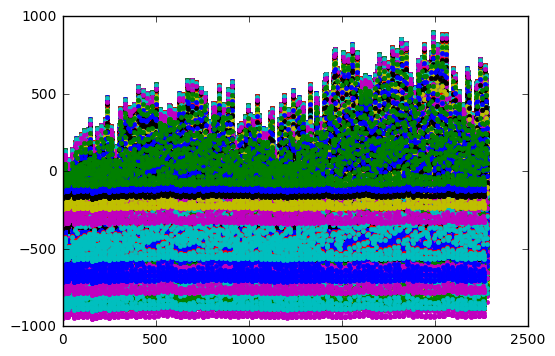

In [11]:
m1 = learn_nn(pre1[0],pre1[1],pre1[2],pre1[3],'MG')
model_eval_nn(m1,pre1)
get_rmsle(m1,pre1)

In [12]:
df_test_test = df_test#.drop(['datetime'], axis = 1)
#df_test_test = df_test_test.drop(['season','workingday','weather','holiday'], axis = 1)
#df_test_t = df_test_test.apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
df_test_test[df_test_test.drop('datetime',axis=1).columns] = df_test_test[df_test_test.drop('datetime',axis=1).columns].apply(lambda x: scalerx.fit_transform(x.reshape(-1,1)).reshape(1,-1)[0] )
df_test_r = preshape_nn(df_test_test)

/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to

In [13]:
pred = m1.predict(df_test_r)
out = scaler.inverse_transform(pred).astype(int)
out[out<0] = 0
out = out[:,0]
from keras.models import load_model
mr = load_model('models/20170113-190313.h5')
df_test_r_r = preshape_nn(df_test_test,1)
predr = scaler.inverse_transform(mr.predict(df_test_r_r)).astype(int)[range(timesteps-1)]
out = np.append(predr,out)
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]
pred.to_csv("pred.csv", index = False)

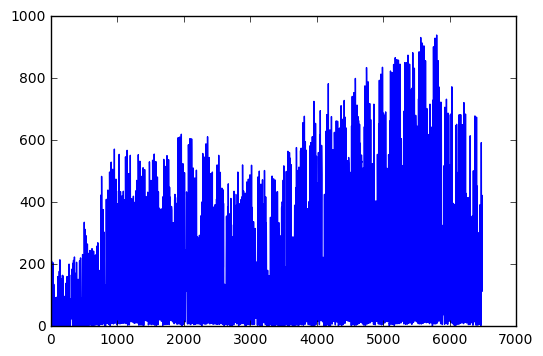

In [14]:
plt.plot(out)

In [ ]:
plt.plot(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0])))-scaler.inverse_transform(pre1[1]),'.')
print scipy.stats.pearsonr(scaler.inverse_transform(m1.predict(preshape_nn(pre1[0]))),scaler.inverse_transform(pre1[1]))[0]

In [ ]:
indexx = pd.DatetimeIndex(df_train['datetime'][df_train['year'] == 2011]).day 
testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
pre2 = preprocess_nn(df_train_train[df_train['year'] == 2011],df_train['casual'][df_train['year'] == 2011])
m2 = learn_nn(pre2[0],pre2[1],pre2[2],pre2[3],'MAC')
model_eval_nn(m2,pre2)
get_rmsle(m2,pre2)

In [ ]:
pre3 = preprocess_nn(df_train_train[df_train['year'] == 2011],df_train['registered'][df_train['year'] == 2011])
m3 = learn_nn(pre3[0],pre3[1],pre3[2],pre3[3],'MAR')
model_eval_nn(m3,pre3)
get_rmsle(m3,pre3)

In [ ]:
indexx = pd.DatetimeIndex(df_train['datetime'][df_train['year'] == 2012]).day 
testindex = np.logical_or(np.logical_or(indexx == 19,indexx == 18),np.logical_or(indexx == 17, indexx == 16))
pre4 = preprocess_nn(df_train_train[df_train['year'] == 2012],df_train['casual'][df_train['year'] == 2012])
m4 = learn_nn(pre4[0],pre4[1],pre4[2],pre4[3],'MBC')
model_eval_nn(m4,pre4)
get_rmsle(m4,pre4)

In [ ]:
pre5 = preprocess_nn(df_train_train[df_train['year'] == 2012],df_train['registered'][df_train['year'] == 2012])
m5 = learn_nn(pre5[0],pre5[1],pre5[2],pre5[3],'MBR')
model_eval_nn(m5,pre5)
get_rmsle(m5,pre5)

In [ ]:
out2 = scaler.inverse_transform(m2.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2011].values.astype('float32'))))).astype(int)
out3 = scaler.inverse_transform(m3.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2011].values.astype('float32'))))).astype(int)
out4 = scaler.inverse_transform(m4.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2012].values.astype('float32'))))).astype(int)
out5 = scaler.inverse_transform(m5.predict(preshape_nn(preprocessing.scale(df_test_test[df_test['year']==2012].values.astype('float32'))))).astype(int)
out2[out2<0] = 0
out3[out3<0] = 0
out4[out4<0] = 0
out5[out5<0] = 0
out2 = out2[:,0]
out3 = out3[:,0]
out4 = out4[:,0]
out5 = out5[:,0]

In [ ]:
outb = np.concatenate((np.array(out2 + out3),np.array(out4 + out5)), axis = 0)
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': outb})
pred = pred[['datetime','count']]
pred.to_csv("pred2.csv", index = False)

In [ ]:
plt.plot(outb)

In [ ]:
plt.plot(out-outb)

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 2
nb_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, nb_classes))

# generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, nb_classes))

model.fit(x_train, y_train,
          batch_size=64, nb_epoch=5,
          validation_data=(x_val, y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/5
1000/1000 [==============================] - 7s - loss: 11.4680 - acc: 0.0920 - val_loss: 11.5496 - val_acc: 0.0900
Epoch 2/5
1000/1000 [==============================] - 3s - loss: 11.4662 - acc: 0.1090 - val_loss: 11.5488 - val_acc: 0.0900
Epoch 3/5
1000/1000 [==============================] - 4s - loss: 11.4660 - acc: 0.1100 - val_loss: 11.5489 - val_acc: 0.0700
Epoch 4/5
1000/1000 [==============================] - 4s - loss: 11.4655 - acc: 0.1270 - val_loss: 11.5481 - val_acc: 0.0600
Epoch 5/5
1000/1000 [==============================] - 3s - loss: 11.4652 - acc: 0.1280 - val_loss: 11.5505 - val_acc: 0.0700
